In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset, DatasetDict
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/CS 6220/Project/inference' # Change the path to the folder where the project is stored in Google Drive.

# Files in the folder -
os.listdir(folder_path)

os.chdir(folder_path)

print('Current working directory -', os.getcwd())

Current working directory - /content/drive/My Drive/CS 6220/Project/inference


# **Import Competition MATH Dataset**

In [ ]:
ds = load_dataset("jeggers/competition_math", "original")

ds['train'] = ds['train'].filter(lambda example: example["level"] != "Level ?")
print(f"There are {len(ds['train'])+len(ds['test'])} addition questions and answers")

train_ds = DatasetDict({
    'train': ds['train'],
    'test': ds['test']
})

There are 12498 addition questions and answers


In [ ]:
def add_index(ds_entry, idx):
    ds_entry['id'] = idx
    return ds_entry

ds['test'] = ds['test'].map(lambda ds_entry, idx: add_index(ds_entry, idx), with_indices=True)
print(ds['test'][0])

{'problem': 'How many vertical asymptotes does the graph of $y=\\frac{2}{x^2+x-6}$ have?', 'level': 'Level 3', 'type': 'Algebra', 'solution': 'The denominator of the rational function factors into $x^2+x-6=(x-2)(x+3)$. Since the numerator is always nonzero, there is a vertical asymptote whenever the denominator is $0$, which occurs for $x = 2$ and $x = -3$.  Therefore, the graph has $\\boxed{2}$ vertical asymptotes.', 'extracted_solution': '2', 'id': 0}


In [ ]:
print(type(ds['test'][123]['extracted_solution']))

<class 'str'>


# **Model #1: Llama 3.1**

In [ ]:
import pandas as pd

correct_answers = [False] * len(ds['test'])
df = pd.read_csv('inference_llama3_competition_math.csv')
print(type(df.iloc[0]['Run_1']))

for i in range(len(ds['test'])):
  if ds['test'][i]['extracted_solution'] == df.iloc[i]['Run_1']:
    correct_answers[i] = True

print(f"Number of correct questions: {sum(correct_answers)}")

<class 'str'>
Number of correct questions: 798


Llama's number of correct answers for math competition dataset

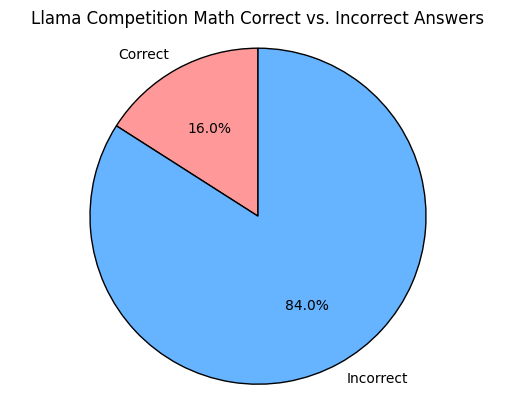

In [ ]:
import matplotlib.pyplot as plt
labels = ['Correct', 'Incorrect']
sizes = [sum(correct_answers), len(ds['test']) - sum(correct_answers)]

colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.title('Llama Competition Math Correct vs. Incorrect Answers')

plt.show()

In-depth Analysis in Algebra answers

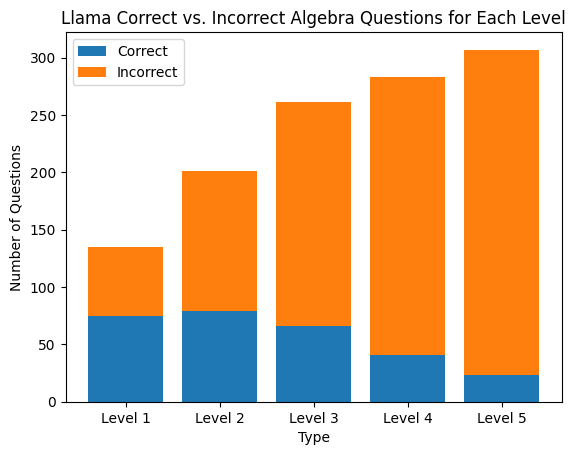

In [ ]:
import numpy as np

total = [0] * 5
correct = [0] * 5

def get_problem_level(problem_level):
  if problem_level == "Level 1":
    return 0
  elif problem_level == "Level 2":
    return 1
  elif problem_level == "Level 3":
    return 2
  elif problem_level == "Level 4":
    return 3
  else:
    return 4

for i in range(len(ds['test'])):
  if ds['test'][i]['type'] == "Algebra":

    problem_level = get_problem_level(ds['test'][i]['level'])
    total[problem_level] += 1
    if correct_answers[i] == True:
      correct[problem_level] += 1

incorrect = np.array(total) - np.array(correct)
levels = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']

fig, ax = plt.subplots()
ax.bar(range(len(total)), correct, label='Correct')
ax.bar(levels, incorrect, bottom=correct, label='Incorrect')

ax.set_xlabel('Type')
ax.set_ylabel('Number of Questions')
ax.set_title('Llama Correct vs. Incorrect Algebra Questions for Each Level')
ax.legend()
plt.show()


# **Model #2: LLemma**